# **CIFAR10**

What about data?

Generally, when you have to deal with image, text, audio or video data, you can use standard python packages that load data into a numpy array. Then you can convert this array into a torch.*Tensor.

- For images, packages such as Pillow, OpenCV are useful
- For audio, packages such as scipy and librosa
- For text, either raw Python or Cython based loading, or NLTK and SpaCy are useful

Specifically for vision, we have created a package called **torchvision**, that has data loaders for common datasets such as Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz., torchvision.datasets and torch.utils.data.DataLoader.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset. It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.


<img src="https://pytorch.org/tutorials/_images/cifar10.png">

**Training Process**

Training an image classifier

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using torchvision
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

In [2]:
#Load the dataset
import torch
import torchvision
import torchvision.transforms as transforms

The first transformation converts the raw data into tensor variables and the second transformation performs normalization using the below operation:

*x_normalized = x-mean / std*

The values 0.5 and 0.5 represent the mean and standard deviation for 3 channels: red, green, and blue.

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]
)

In [6]:
trainset = torchvision.datasets.CIFAR10(root='./data' , train = True,
                                        download=True,transform = transform)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=4,
                                          shuffle = True,num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data',train=False,
                                       download=True,transform=transform)
testloader = torch.utils.data.DataLoader(testset,batch_size=4,
                                         shuffle = True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


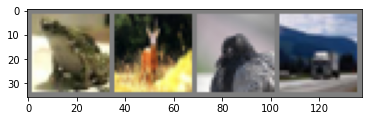

 frog  deer  bird truck


In [11]:
#Lets show some images from dataset
#https://pytorch.org/docs/stable/data.html
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
  img = img/2+0.5 #unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.show()

fromdatasetiter = iter(trainloader)
images , labels = fromdataset.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s'% classes[labels[j]] for j in range(4)))

**Define a Convolutional Neural Network**

In [31]:
#Conv2d(input_channel , output_channel , Kernel_size)
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [32]:
#Define a loss function and optimizer
import torch.optim as optim

net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Train the Network

In [33]:
for epoch in range(2):
    running_loss = 0.0
    for i , data in enumerate(trainloader,0):
      inputs , labels = data

      optimizer.zero_grad()

      #forward + backward + optimizer
      outputs = net(inputs)
      loss = criterion(outputs,labels)
      loss.backward()
      optimizer.step()

      #print values
      running_loss +=loss.item()
      if i % 2000 == 1999:
        print('[%d,%5d] loss:%.3f' %
              (epoch +1 , i+1 , running_loss / 2000))
        running_loss = 0.0

print('Finished Traning')

[1, 2000] loss:2.213
[1, 4000] loss:1.862
[1, 6000] loss:1.683
[1, 8000] loss:1.615
[1,10000] loss:1.526
[1,12000] loss:1.465
[2, 2000] loss:1.401
[2, 4000] loss:1.364
[2, 6000] loss:1.343
[2, 8000] loss:1.328
[2,10000] loss:1.316
[2,12000] loss:1.296
Finished Traning


Test the Network on the test data

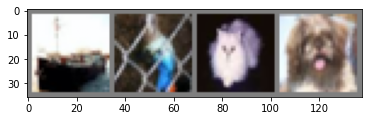

GroundTruth:  ship  bird   cat   dog


In [38]:
dataiter = iter(testloader)
images , labels = dataiter.next()

#print_images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth:' , ' '.join('%5s' %classes[labels[j]] for j in range(4)))

In [40]:
#Let us look at how the network performs on the whole dataset.

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


Accuracy of the network on the 10000 test images: 53 %


In [41]:
#Lets see the accuracy over different classed
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 65 %
Accuracy of   car : 52 %
Accuracy of  bird : 35 %
Accuracy of   cat : 44 %
Accuracy of  deer : 29 %
Accuracy of   dog : 40 %
Accuracy of  frog : 84 %
Accuracy of horse : 52 %
Accuracy of  ship : 67 %
Accuracy of truck : 65 %


---

END